## Portugal Electricity Mix

In [20]:
# Imports and API


import requests, time, json
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm   
import matplotlib.pyplot as plt
from requests.adapters import HTTPAdapter, Retry
from pathlib import Path



%matplotlib inline



In [15]:
API = ("https://servicebus.ren.pt/datahubapi/electricity/"
       "ElectricityConsumptionSupplyDaily")

# ▶️ sesión con reintentos exponenciales
def make_session(retries=5, backoff=0.5) -> requests.Session:
    retry = Retry(
        total=retries,             # nº máx. de reintentos
        backoff_factor=backoff,    # 0.5 → 0.5s, 1s, 2s, 4s…
        status_forcelist=[500, 502, 503, 504],
        allowed_methods=["GET"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    sess = requests.Session()
    sess.mount("https://", adapter)
    return sess

session = make_session()

def fetch_day(date_str, culture="pt-PT", read_timeout=60):
    url = f"{API}?culture={culture}&date={date_str}"
    r = session.get(url, timeout=(10, read_timeout))  # 10 s para conectar, 60 s para leer
    r.raise_for_status()
    data = r.json()
    if not data or isinstance(data, dict):
        return None
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(date_str)
    return df

In [16]:
start = datetime(2021, 5, 21)
end   = datetime(2023, 4, 30)

frames = []
for day in tqdm(list(daterange(start, end)), desc="Descargando"):
    df = fetch_day(day.strftime("%Y-%m-%d"))
    if df is not None:
        frames.append(df)
    time.sleep(0.3)   # evita sobrecargar el servidor

consumo_raw = pd.concat(frames, ignore_index=True)
print(f"{len(consumo_raw)} filas descargadas.")



Descargando:   0%|          | 0/710 [00:00<?, ?it/s]

17248 filas descargadas.


In [17]:
pivot = consumo_raw.pivot_table(index="date",
                                columns="type",
                                values="daily_Accumulation",
                                aggfunc="sum").fillna(0)

pivot.head()          # primera vista


type,BIOMASSA,BIOMASSA_COGERACAO,BIOMASSA_OUTROS,CARVAO,CONSUMO,CONSUMO_ARMAZENAMENTO,CONSUMO_BOMBAGEM,CORRIGIDO_TEMPERATURA,EOLICA,EXPORTACAO,...,OUTRA_TERMICA,OUTRA_TERMICA_COGERACAO,OUTRA_TERMICA_OUTROS,PRODUCAO_ARMAZENAMENTO,PRODUCAO_BOMBAGEM,PRODUCAO_NAO_RENOVAVEL,PRODUCAO_RENOVAVEL,PRODUCAO_TOTAL,SALDO_IMPORTADOR,SOLAR
date,,,,,,,,,,,,,,,,,,,,,
2021-05-21,10.0,5.0,5.0,0.0,133.0,5.0,5.0,133.0,45.0,7.0,...,1.0,0.0,1.0,6.0,6.0,42.0,71.0,119.0,19.0,6.0
2021-05-22,10.0,5.0,5.0,0.0,117.0,5.0,5.0,117.0,49.0,5.0,...,1.0,0.0,1.0,5.0,5.0,10.0,80.0,95.0,27.0,5.0
2021-05-23,9.0,5.0,5.0,0.0,108.0,13.0,13.0,108.0,59.0,3.0,...,1.0,0.0,1.0,2.0,2.0,8.0,84.0,95.0,27.0,7.0
2021-05-24,9.0,4.0,5.0,0.0,129.0,13.0,13.0,129.0,47.0,8.0,...,1.0,0.0,1.0,5.0,5.0,22.0,77.0,104.0,38.0,5.0
2021-05-25,8.0,3.0,5.0,0.0,133.0,0.0,0.0,133.0,35.0,13.0,...,1.0,0.0,1.0,10.0,10.0,44.0,68.0,123.0,10.0,6.0


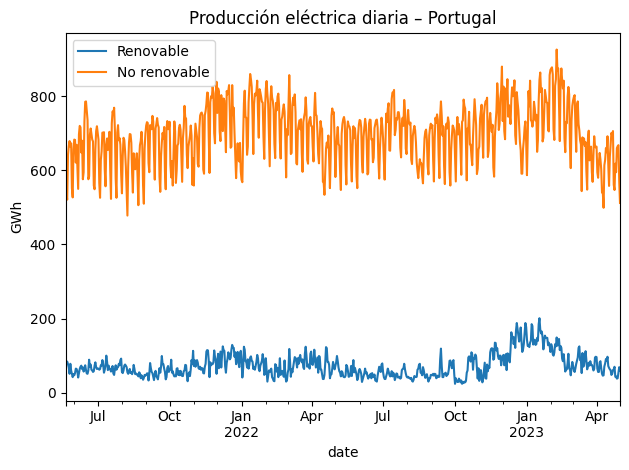

In [22]:
# build the path one level up, inside data/generation_data
out_path = Path("..") / "data" / "generation_data"
out_path.mkdir(parents=True, exist_ok=True)   # creates ../data/generation_data/

pivot.to_csv(out_path / "consumo_PT_2021-05-21_2023-04-30.csv",
             encoding="utf-8",
             index=False)

# Ejemplo: pila apilada de producción renovable vs. no renovable
ren = ["EOLICA", "HIDRICA", "SOLAR", "BIOMASSA"]
non_ren = [c for c in pivot.columns if c not in ren]

pivot[ren].sum(axis=1).plot(label="Renovable")
pivot[non_ren].sum(axis=1).plot(label="No renovable")
plt.title("Producción eléctrica diaria – Portugal")
plt.ylabel("GWh")
plt.legend()
plt.tight_layout()
plt.show()


## France

In [31]:
import requests, pprint, pandas as pd, datetime as dt
from tqdm.notebook import tqdm
import datetime as dt
import numpy as np


In [28]:


meta = requests.get(
    "https://odre.opendatasoft.com/api/v2/catalog/datasets/"
    "eco2mix-national-cons-def"
).json()

# imprime solo la lista de nombres
pprint.pp([f["name"] for f in meta["dataset"]["fields"]])


['perimetre',
 'nature',
 'date',
 'heure',
 'date_heure',
 'consommation',
 'prevision_j1',
 'prevision_j',
 'fioul',
 'charbon',
 'gaz',
 'nucleaire',
 'eolien',
 'solaire',
 'hydraulique',
 'pompage',
 'bioenergies',
 'ech_physiques',
 'taux_co2',
 'ech_comm_angleterre',
 'ech_comm_espagne',
 'ech_comm_italie',
 'ech_comm_suisse',
 'ech_comm_allemagne_belgique',
 'fioul_tac',
 'fioul_cogen',
 'fioul_autres',
 'gaz_tac',
 'gaz_cogen',
 'gaz_ccg',
 'gaz_autres',
 'hydraulique_fil_eau_eclusee',
 'hydraulique_lacs',
 'hydraulique_step_turbinage',
 'bioenergies_dechets',
 'bioenergies_biomasse',
 'bioenergies_biogaz']


In [29]:
FIELDS = [
    "date_heure",          # marca de tiempo
    "consommation",        # carga total
    # Renovables
    "eolien",
    "solaire",
    # Hidráulica (suma de sub-tipos más abajo)
    "hydraulique_fil_eau_eclusee",
    "hydraulique_lacs",
    "hydraulique_step_turbinage",
    # Fósiles
    "gaz_tac", "gaz_cogen", "gaz_ccg", "gaz_autres",
    "fioul_tac", "fioul_cogen", "fioul_autres",
    "charbon",
    # Nuclear
    "nucleaire",
    # Bioenergías
    "bioenergies_dechets", "bioenergies_biogaz", "bioenergies_biomasse",
    # Intercambios y CO₂ (opcional)
    "ech_physiques", "taux_co2"
]


In [33]:

BASE = "https://odre.opendatasoft.com/api/v2/catalog/datasets"
DATASET = "eco2mix-national-cons-def"



def fetch_interval(start_iso: str, end_iso: str, batch: int = 100) -> pd.DataFrame:
    """Descarga todos los registros entre start_iso y end_iso (YYYY-MM-DD)."""
    all_rows, offset = [], 0
    while True:
        params = {
            "select": ",".join(FIELDS),
            "where": f"date_heure >= '{start_iso}' AND date_heure < '{end_iso}'",
            "limit": batch,
            "offset": offset,
            "timezone": "Europe/Paris",
            # ordenamos para que el streaming sea estable
            "order_by": "date_heure"
        }
        r = requests.get(f"{BASE}/{DATASET}/records", params=params, timeout=60)
        if r.status_code != 200:
            raise RuntimeError(f"API {r.status_code}: {r.text}")  # muestra causa exacta
        page = r.json().get("results", [])
        if not page:                        # sin más filas -> salimos
            break
        all_rows.extend(page)
        if len(page) < batch:               # última página
            break
        offset += batch                     # siguiente bloque
    return pd.json_normalize(all_rows)

In [34]:
t0, t1 = dt.date(2021, 5, 21), dt.date(2023, 4, 30)
step   = dt.timedelta(days=31)

frames, cur = [], t0
while cur <= t1:
    nxt = min(cur + step, t1 + dt.timedelta(days=1))
    frames.append(fetch_interval(cur.isoformat(), nxt.isoformat()))
    cur = nxt

raw = pd.concat(frames, ignore_index=True)
